The times taken to query the base galaxy Table using obsMetadata and instance Catalogs is much larger than the time to query the galaxy table on fatboy directly. This records timeit results for these queries

## Setup

In [1]:
from __future__ import division, print_function, absolute_import

In [2]:
import time
import os
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject, DBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj, GalaxyObj
from lsst.sims.utils import ObservationMetaData

/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


## galaxy Instance Catalog + writeCatalog

In [4]:
observerMetaData = ObservationMetaData(boundType='box',
                                  pointingRA=0.,
                                  pointingDec=0.,
                                  boundLength=2.)

In [5]:
observerMetaData.boundLength

2.0

In [6]:
def tileObsMetaData(obsMetaData, num):
    ra, dec, size = obsMetaData.pointingRA, obsMetaData.pointingDec, obsMetaData.boundLength
    blen = size / num
    pras = np.arange(ra - size, ra + size, 2.0 *blen) + blen
    pdecs = np.arange(dec - size, dec + size, 2.0 * blen) + blen
    
    coords = np.dstack(np.meshgrid(pras, pdecs)).reshape(len(pras) * len(pdecs), 2)
    obsmdata = [ObservationMetaData(boundType='box',
                                  pointingRA=coords[i, 0],
                                  pointingDec=coords[i, 1],
                                  boundLength=blen) for i in range(len(coords))]
    # return coords
    diffvec = np.array([blen, blen])
    transvec = np.array([1, -1])
    verts = [[coord - diffvec, coord - transvec * diffvec, coord + diffvec, coord + diffvec *transvec] for coord in coords]  
    bounds = [Polygon(vert, fill=False, lw=2, alpha=1., ls='dashed') for vert in verts]
    return obsmdata, coords, bounds



(-2.0, 2.0)

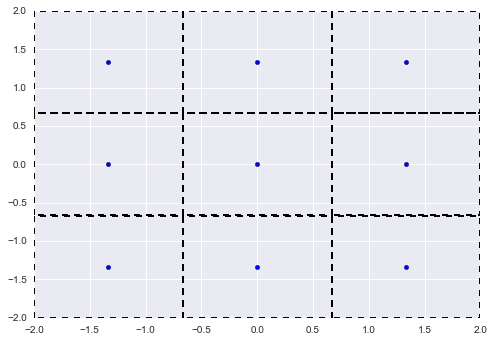

In [7]:
tiledObsMD, coords, bounds = tileObsMetaData(observerMetaData, 3)
fig, ax =plt.subplots()
ax.scatter(coords[:,0], coords[:, 1])
for bound in bounds:
    ax.add_patch(bound)
ax.set_xlim(-2., 2.)
ax.set_ylim(-2., 2.)

In [44]:
len(tiledObsMD)

9

In [8]:
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

In [9]:
def writeCat(obsMD=tiledObsMD, redshiftmax=0.4, fname='gB-test', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyTiled = GalaxyTileObj()
    print(len(obsMD))
    filenames = []
    for i, obsMetaData in enumerate(obsMD):
        filename = fname  + '{}'.format(i) + '.csv'
        filenames.append(filename)
        galaxyBase = galCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
        galaxyBase.write_catalog(filename, chunkSize)
    return filenames

In [10]:
# No need
def writeCatBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyTiled = GalaxyObj()
    galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    galaxyBase.write_catalog(fname, chunkSize)

In [15]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 1)

In [16]:
len(tileObsMD)

1

In [17]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

1
['gB-test0.csv']
53.5084130764
1
['gB-test0.csv']
53.0326910019
1
['gB-test0.csv']
56.5730910301
1
['gB-test0.csv']
51.4206521511
1 loops, best of 3: 51.4 s per loop


/usr/local/manual/anaconda/lib/python2.7/site-packages/sqlalchemy/dialects/mssql/base.py:1294: SAWarning: Did not recognize type 'geography' of column 'geopoint'
  return fn(*arg, **kw)


In [19]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 2)

In [20]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

4
['gB-test0.csv', 'gB-test1.csv', 'gB-test2.csv', 'gB-test3.csv']
65.6345999241
4
['gB-test0.csv', 'gB-test1.csv', 'gB-test2.csv', 'gB-test3.csv']
65.4557840824
4
['gB-test0.csv', 'gB-test1.csv', 'gB-test2.csv', 'gB-test3.csv']
64.9600560665
4
['gB-test0.csv', 'gB-test1.csv', 'gB-test2.csv', 'gB-test3.csv']
67.5456387997
1 loops, best of 3: 1min 4s per loop


In [22]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 3)

In [24]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

9
['gB-test0.csv', 'gB-test1.csv', 'gB-test2.csv', 'gB-test3.csv', 'gB-test4.csv', 'gB-test5.csv', 'gB-test6.csv', 'gB-test7.csv', 'gB-test8.csv']
142.366191864
9
['gB-test0.csv', 'gB-test1.csv', 'gB-test2.csv', 'gB-test3.csv', 'gB-test4.csv', 'gB-test5.csv', 'gB-test6.csv', 'gB-test7.csv', 'gB-test8.csv']
133.498877048
9
['gB-test0.csv', 'gB-test1.csv', 'gB-test2.csv', 'gB-test3.csv', 'gB-test4.csv', 'gB-test5.csv', 'gB-test6.csv', 'gB-test7.csv', 'gB-test8.csv']
137.501379013
9
['gB-test0.csv', 'gB-test1.csv', 'gB-test2.csv', 'gB-test3.csv', 'gB-test4.csv', 'gB-test5.csv', 'gB-test6.csv', 'gB-test7.csv', 'gB-test8.csv']
114.320805073
1 loops, best of 3: 1min 54s per loop


In [26]:
query = """EXECUTE [LSSTCATSIM].[dbo].[GalaxySearch2015l]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4’
        """


In [39]:
numLines = 1
for i in range(9):
    fname = "gB-test{}.csv".format(i)
    with open(fname, 'r') as fp:
        numLines += sum(1 for line in fp) - 1 

In [40]:
print(numLines)

907566


In [42]:
!tail gB-test0.csv

402703942370, 6.269012e+00, -3.350477e-02, 0.2825
402707658789, 6.269316e+00, -3.308684e-02, 0.2820
402706510296, 6.268263e+00, -3.367106e-02, 0.2904
402714836724, 6.268873e+00, -3.305237e-02, 0.2913
402712416481, 6.268725e+00, -3.316881e-02, 0.2852
402701897088, 6.269290e+00, -3.234776e-02, 0.2926
402701284534, 6.269248e+00, -3.244175e-02, 0.2872
402713636369, 6.268701e+00, -3.285739e-02, 0.2922
402701287465, 6.268644e+00, -3.278622e-02, 0.2871
402702290467, 6.268684e+00, -3.277895e-02, 0.2840


In [61]:
!wc -l *.csv

   35307 gB-test.csv
  907563 gb_pd.test.csv
    4952 results.csv
  947822 total


In [51]:
def writeDBObjBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyBase = GalaxyTileObj()
    # galDB = dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)
    #galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    query = """SELECT galtileid, raJ2000, decJ2000, redshift FROM galaxy WHERE redshift < 0.4 AND raJ2000 < 2 and raJ2000 > -2 and decJ2000 < 2 and decJ2000 > -2"""
    x = galaxyBase.execute_arbitrary(query)
    print(len(x), len(x[0]))
    #galaxyBase.write_catalog(fname, chunkSize)

In [53]:
def writeDBObjBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyBase = GalaxyObj()
    # galDB = dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)
    #galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    query = """SELECT id, ra, dec, redshift WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
    x = galaxyBase.execute_arbitrary(query)
    print(len(x), len(x[0]))
    #galaxyBase.write_catalog(fname, chunkSize)

In [54]:
%%timeit
chunksize = None
tstart = time.time()
writeDBObjBase(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

ProgrammingError: (ProgrammingError) (207, "Invalid column name 'redshift'.DB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\nDB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\n") 'SELECT id, ra, dec, redshift WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2' {}

In [25]:
%%timeit
chunksize = None
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

TypeError: writeCat() takes at least 1 argument (1 given)

In [8]:
%%timeit
chunksize = 50000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

52.747150898
50.3756668568
52.9057190418
50.5252020359
1 loops, best of 3: 50.4 s per loop


In [9]:
%%timeit
chunksize = 500000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

51.8218009472
49.6426441669
52.1382918358
55.8443951607
1 loops, best of 3: 49.6 s per loop


In [10]:
%%timeit
chunksize = 5000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

52.6447761059
52.5556430817
50.3972399235
49.5057430267
1 loops, best of 3: 49.5 s per loop


In [15]:
%%timeit
chunksize = 50
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

54.0655651093
54.7553839684
55.7499918938
56.8625900745
1 loops, best of 3: 54.8 s per loop


In [48]:
# No need
class galBaseCopy(InstanceCatalog):
    column_outputs = ['id', 'raJ2000', 'decJ2000', 'redshift']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

## Direct query with fetch

In [5]:
from lsst.utils import getPackageDir
from lsst.daf.persistence import DbAuth
import lsst.pex.config as pexConfig
import pymssql

In [6]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

907562 4
4.23498082161
907562 4
4.48394203186
907562 4
4.17997217178
907562 4
4.08686304092
1 loops, best of 3: 4.09 s per loop


In [7]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

907562 4
4.3362429142
907562 4
4.18236804008
907562 4
3.96533608437
907562 4
4.23153018951
1 loops, best of 3: 3.97 s per loop


In [10]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """EXECUTE [LSSTCATSIM].[dbo].[GalaxySearch2015]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4'
"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

907563 4
46.176625967
907563 4
45.385848999
907563 4
43.733784914
907563 4
45.7231371403
1 loops, best of 3: 43.7 s per loop


In [11]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """[LSSTCATSIM].[dbo].[GalaxySearch2015]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4'"""

db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

907563 4
43.7366120815
907563 4
46.5016469955
907563 4
44.2484331131
907563 4
45.9520299435
1 loops, best of 3: 44.2 s per loop


In [15]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
num = 50000
x = db.fetchmany(num)
while len(x)>0:
    x = db.fetchmany(num)
# print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

9.61898994446
7.99610805511
9.97264313698
7.94437718391
1 loops, best of 3: 7.94 s per loop


In [7]:
!pwd

/Users/rbiswas/src/LSST/BenchmarkInstanceCatalogs/examples


In [10]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

38.0828609467
48.4139699936
46.8077619076
42.6143682003
1 loops, best of 3: 42.6 s per loop


In [11]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
num = 50000
x = db.fetchmany(num)
while len(x) > 0:
    x = db.fetchmany(num)
# print(len(x), len(x[0]))
#df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
#df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

NameError: global name 'getPackageDir' is not defined

In [14]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

5.25460505486
5.22433400154
5.32429909706
5.30123806
1 loops, best of 3: 5.22 s per loop


In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [23]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT galaxy.id AS id, ra*PI()/180. AS [raJ2000], dec*PI()/180. AS [decJ2000], galaxy.redshift AS redshift 
FROM galaxy  WITH(FORCESEEK) JOIN (SELECT htmidstart, htmidend 
FROM fHtmCoverRegion(%(fHtmCoverRegion_1)s)) AS anon_1 ON galaxy.htmid BETWEEN anon_1.htmidstart AND anon_1.htmidend 
WHERE sph.fRegionContainsXYZ(sph.fSimplifyString(%(fSimplifyString_1)s), galaxy.cx, galaxy.cy, galaxy.cz) = %(fRegionContainsXYZ_1)s
"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

ProgrammingError: (102, "Incorrect syntax near '('.DB-Lib error message 20018, severity 15:\nGeneral SQL Server error: Check messages from the SQL Server\n")

In [26]:
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)



In [35]:
config

lsst.sims.catUtils.baseCatalogModels.BaseCatalogModels.BaseCatalogConfig(host='localhost', driver='mssql+pymssql', port='51433', database='LSSTCATSIM')

In [36]:
dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)

In [ ]:
dbobject.execute_arbitrary()